## 一、 准备环境环境

### 1. 安装必要的python包

In [ ]:
%pip install graphrag

### 2. 申请api-key
[deepseek 注册免费送500万token](https://deepseek.com/)

[chatglm 注册免费送2500万token](https://open.bigmodel.cn/)

### 3. 测试API接口是否联通

In [1]:
import openai

client = openai.Client(base_url="https://open.bigmodel.cn/api/paas/v4/", api_key="")
response = client.embeddings.create(
    model="embedding-2",
    input="你好"
)

print(response)

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.02675455, 0.019045718, 0.006664881, -0.023293389, 0.0015206569, -0.04486882, -0.042575654, -0.0068752086, 0.041466173, 0.063009225, -0.02054925, 0.02197032, 0.010770192, 0.029588338, -0.014666274, -0.0125894295, 0.0041863034, 0.03300969, 0.00084172003, 0.03833367, 0.011762664, 0.015289724, -0.02257108, -0.0042375927, 0.004333133, -0.020114154, 0.0082468465, -0.029370125, -0.028433055, -0.03754437, 0.020863462, 0.0025333231, -0.010941108, 0.014648178, 0.023267869, 0.054538768, -0.0021926227, 0.045446496, 0.03306297, -0.029986374, -0.039381802, 0.0035400314, -0.01769706, -0.058106888, 0.02672521, 0.008502675, 0.041842893, 0.04273137, 0.027076239, 0.0016063545, 0.015132259, 0.0006472097, 0.0018888881, 0.011831868, 0.029406136, 0.035970062, 0.03429845, 0.011271943, -0.026558371, 0.0523376, -0.027810996, 0.030679826, -0.025549809, 0.023770476, 0.021686101, 0.05622286, 0.010020599, -0.008720338, -0.024514034, -0.033823732, 0.006750432, -0

In [5]:
import openai

client = openai.Client(base_url="https://api.deepseek.com", api_key="")
response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[{"role": "user", "content": "你会什么？"}]
)

print(response)

ChatCompletion(id='5a56ac9011df6a933882ddc98ddb512e', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='作为一个通用领域的人工智能，我可以帮助您回答问题，提供信息，或者进行愉快的聊天。您不管有什么话题都可以找我聊聊~', role='assistant', function_call=None, tool_calls=None))], created=1722149917, model='deepseek-chat', object='chat.completion', service_tier=None, system_fingerprint='fp_7e0991cad4', usage=CompletionUsage(completion_tokens=31, prompt_tokens=6, total_tokens=37))


### 4. 进行global 查询

In [ ]:
import os

import pandas as pd
import tiktoken

from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

# 1. Setup LLM
api_key = ""
llm_model = "deepseek-chat"
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,
    max_retries=20,
    api_base="https://api.deepseek.com"
)
token_encoder = tiktoken.get_encoding("cl100k_base")

# 2. Load Context
INPUT_DIR = "./output/20240727-225047/artifacts"
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 2   # 如果觉得不准确， 可以提高这个参数。

entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Report records: {len(report_df)}")
report_df.head()

context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,
    token_encoder=token_encoder,
)

# 3. Setup Global Search
context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1000,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 2000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": 0.0,
}


search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)



- Question： 1

In [7]:
query = "毗蓝婆 是谁？ 跟行者的关系?"
result = await search_engine.asearch(query)
print(result.response)
result.context_data["reports"].to_csv("report.csv", encoding='utf-8-sig', index=False)
print(f"LLM calls: {result.llm_calls}. LLM tokens: {result.prompt_tokens}")

毗蓝婆是一位在佛教故事中具有重要地位的菩萨。她有多个别称，包括毗蓝菩萨和观音菩萨的化身之一。毗蓝婆在社区中扮演着核心角色，经常帮助行者解决困难，显示了她在社区中的重要影响力和作用[Data: Reports (229)]。

毗蓝婆菩萨居住在千花洞，是一位精通佛法的女道姑，隐姓埋名三百余年。她在关键时刻展现出决策能力，例如在大圣寻求帮助时，她同意帮助对抗黄花观道士[Data: Reports (135)]。

在降服蜈蚣精的事件中，毗蓝婆使用其特殊的绣花针成功降服了蜈蚣精，行者也见证并参与了这一行动，显示了他们之间的合作关系[Data: Reports (178)]。这种合作关系不仅体现了毗蓝婆的强大能力，也展示了她与行者之间的紧密联系。
LLM calls: 18. LLM tokens: 202785


原回答：

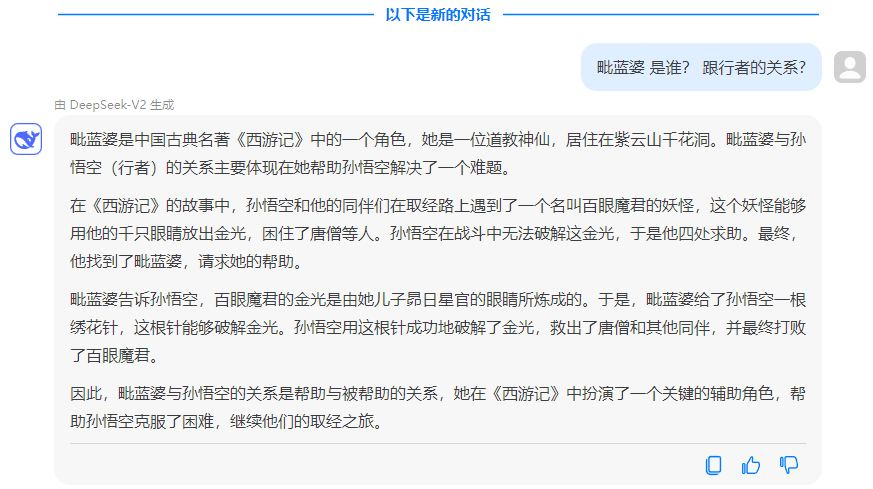

- Question： 2

In [8]:
query = "毗蓝婆 是谁？ 跟孙悟空的关系?"
result = await search_engine.asearch(query)
print(result.response)
result.context_data["reports"].to_csv("report2.csv", encoding='utf-8-sig', index=False)
print(f"LLM calls: {result.llm_calls}. LLM tokens: {result.prompt_tokens}")

毗蓝婆是毗蓝菩萨的别称，她在多个故事中扮演了重要角色。她被描述为观音菩萨的化身之一，与孙悟空有着密切的关系。毗蓝婆菩萨是一位居住在千花洞的女道姑，精通佛法，隐姓埋名三百余年。她在关键时刻多次帮助孙悟空和唐僧解决困难，显示了她在社区中的核心地位和重要作用。

在降服蜈蚣精事件中，毗蓝婆使用其特殊的绣花针成功降服了蜈蚣精，而孙悟空（行者）也见证并参与了这一行动，共同对抗了蜈蚣精，显示了他们之间的合作关系 [Data: Reports (178)]。此外，大圣曾寻求毗蓝婆菩萨的帮助以对抗黄花观道士，毗蓝婆菩萨最终同意帮助大圣，这种关系进一步显示了毗蓝婆菩萨在社区中的影响力和她在关键时刻的决策能力 [Data: Reports (135)]。

总的来说，毗蓝婆与孙悟空的关系体现在她多次在关键时刻帮助孙悟空和唐僧解决困难，包括制服妖怪和保护他们前往西天取经。这种关系不仅显示了观音菩萨对孙悟空的影响，也揭示了潜在的救赎可能性。
LLM calls: 18. LLM tokens: 202937


原回答：

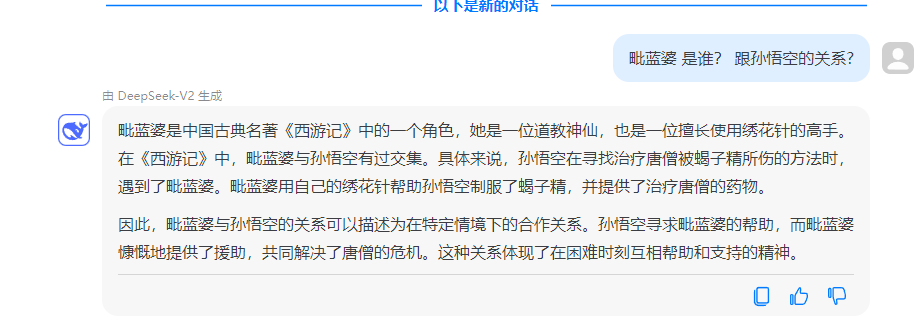